<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Hyperparameter Tuning

## *Data Science Unit 4 Sprint 2 Assignment 4*

## Your Mission, should you choose to accept it...

To hyperparameter tune and extract every ounce of accuracy out of this telecom customer churn dataset: [Available Here](https://lambdaschool-data-science.s3.amazonaws.com/telco-churn/WA_Fn-UseC_-Telco-Customer-Churn+(1).csv)

## Requirements

- Load the data
- Clean the data if necessary (it will be)
- Create and fit a baseline Keras MLP model to the data.
- Hyperparameter tune (at least) the following parameters:
 - batch_size
 - training epochs
 - optimizer
 - learning rate (if applicable to optimizer)
 - momentum (if applicable to optimizer)
 - activation functions
 - network weight initialization
 - dropout regularization
 - number of neurons in the hidden layer
 
 You must use Grid Search and Cross Validation for your initial pass of the above hyperparameters
 
 Try and get the maximum accuracy possible out of this data! You'll save big telecoms millions! Doesn't that sound great?


In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
# load data
cdata = pd.read_csv('https://lambdaschool-data-science.s3.amazonaws.com/telco-churn/WA_Fn-UseC_-Telco-Customer-Churn+(1).csv')
cdata.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
print(cdata.shape)
cdata.columns
# target is churn

(7043, 21)


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [4]:
cdata.isnull().sum()
# no nulls to replace

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
# clean the dataset
# drop customer ID/unique 
cdata = cdata.drop(columns=['customerID', 'MultipleLines'])


# ordinal encode categorical columns 
yncols = ['Partner', 'Dependents','PhoneService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
for col in yncols:
  cdata[col].replace({'Yes': 1, 'No': 0, 'No internet service': 0}, inplace=True)

# cdata['MultipleLines'] = cdata['MultipleLines'].replace({'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0})
cdata['gender'].replace({'Female': 1, 'Male': 2}, inplace = True)
cdata['InternetService'].replace({'No': 0,'DSL': 1,'Fiber optic': 2}, inplace=True)
cdata['Contract'].replace({'Month-to-month': 1, 'One year': 2, 'Two year': 3}, inplace=True)
cdata['PaymentMethod'].replace({'Electronic check': 1,'Credit card (automatic)': 2, 'Bank transfer (automatic)': 3,  'Mailed check': 4}, inplace=True)

# make numeric columns float
cdata['MonthlyCharges'] = pd.to_numeric(cdata['MonthlyCharges'].replace(' ', 0))
cdata['TotalCharges'] = pd.to_numeric(cdata['TotalCharges'].replace(' ', 0))
cdata['MonthlyCharges'].astype(float)
cdata['TotalCharges'].astype(float)

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [6]:
# normalize
from sklearn.preprocessing import Normalizer
norm = Normalizer()
y = cdata['Churn'] # target
X = cdata.drop(columns = ['Churn'])
X = norm.fit_transform(X)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test = np.asarray(y_test)
y_train = np.asarray(y_train)

input = X_train.shape[1]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5634, 18) (1409, 18) (5634,) (1409,)


In [8]:
y.value_counts(normalize=True)
# majority class: majority of customers (~73%) do not churn

0    0.73463
1    0.26537
Name: Churn, dtype: float64

In [9]:
X.shape

(7043, 18)

In [10]:
# Baseline Keras MLP model
# i think it should have 18 input nodes matching number of features & 2 output nodes matching 2 target classes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
model = Sequential()
model.add(Dense(19, activation='relu', input_shape=(input,)))
model.add(Dense(1, activation='sigmoid'))

# compile 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

baseline = model.fit(X, y, epochs=20, validation_split=0.2)

Epoch 1/20
177/177 [==============================] - 0s 1ms/step - loss: 0.6346 - accuracy: 0.6782 - val_loss: 0.5804 - val_accuracy: 0.7296
Epoch 2/20
177/177 [==============================] - 0s 657us/step - loss: 0.5618 - accuracy: 0.7359 - val_loss: 0.5516 - val_accuracy: 0.7296
Epoch 3/20
177/177 [==============================] - 0s 679us/step - loss: 0.5450 - accuracy: 0.7343 - val_loss: 0.5375 - val_accuracy: 0.7282
Epoch 4/20
177/177 [==============================] - 0s 658us/step - loss: 0.5352 - accuracy: 0.7506 - val_loss: 0.5271 - val_accuracy: 0.7644
Epoch 5/20
177/177 [==============================] - 0s 664us/step - loss: 0.5289 - accuracy: 0.7517 - val_loss: 0.5204 - val_accuracy: 0.7637
Epoch 6/20
177/177 [==============================] - 0s 656us/step - loss: 0.5241 - accuracy: 0.7524 - val_loss: 0.5163 - val_accuracy: 0.7665
Epoch 7/20
177/177 [==============================] - 0s 661us/step - loss: 0.5195 - accuracy: 0.7561 - val_loss: 0.5112 - val_accuracy: 0

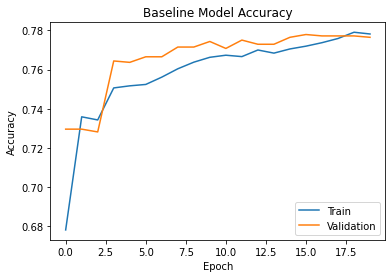

In [11]:
# plot baseline training vs validation accuracy
plt.plot(baseline.history['accuracy'])
plt.plot(baseline.history['val_accuracy'])
plt.title('Baseline Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [12]:
# tune Hyperparameters
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(Dense(18, input_shape=(input,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# instantiate
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {'batch_size': [10, 20, 40, 60, 80, 100],
              'epochs': [20]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Best: 0.7779562115669251 using {'batch_size': 10, 'epochs': 20}
Means: 0.7779562115669251, Stdev: 0.007757256705286448 with: {'batch_size': 10, 'epochs': 20}
Means: 0.77174471616745, Stdev: 0.014074124710622107 with: {'batch_size': 20, 'epochs': 20}
Means: 0.7674853205680847, Stdev: 0.011278804004557936 with: {'batch_size': 40, 'epochs': 20}
Means: 0.7657089591026306, Stdev: 0.010421596348478432 with: {'batch_size': 60, 'epochs': 20}
Means: 0.7639338612556458, Stdev: 0.009324648617863203 with: {'batch_size': 80, 'epochs': 20}
Means: 0.7609174728393555, Stdev: 0.01053217968601607 with: {'batch_size': 100, 'epochs': 20}


In [13]:
# add optimizer
from tensorflow.keras.optimizers import Adam

def create_model():
    model = Sequential()
    model.add(Dense(18, input_shape=(input,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=.001)
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# instantiate
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {'batch_size': [10, 20, 40, 60, 80, 100],
              'epochs': [20]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Best: 0.7756490588188172 using {'batch_size': 10, 'epochs': 20}
Means: 0.7756490588188172, Stdev: 0.011940489176630341 with: {'batch_size': 10, 'epochs': 20}
Means: 0.7694375395774842, Stdev: 0.01089062370141252 with: {'batch_size': 20, 'epochs': 20}
Means: 0.7658867359161377, Stdev: 0.011929239220403823 with: {'batch_size': 40, 'epochs': 20}
Means: 0.7658875226974488, Stdev: 0.010389932763577367 with: {'batch_size': 60, 'epochs': 20}
Means: 0.7642894148826599, Stdev: 0.009064139351614616 with: {'batch_size': 80, 'epochs': 20}
Means: 0.7575450658798217, Stdev: 0.008766700745996177 with: {'batch_size': 100, 'epochs': 20}


In [14]:
# add optimizer
from tensorflow.keras.optimizers import Adam

def create_model():
    model = Sequential()
    model.add(Dense(18, input_shape=(input,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=.001)
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# instantiate
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {'batch_size': [10, 20, 40, 60, 80, 100],
              'epochs': [40]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Best: 0.7841681838035583 using {'batch_size': 10, 'epochs': 40}
Means: 0.7841681838035583, Stdev: 0.009466031030862415 with: {'batch_size': 10, 'epochs': 40}
Means: 0.7809737086296081, Stdev: 0.00836087318080758 with: {'batch_size': 20, 'epochs': 40}
Means: 0.7713891744613648, Stdev: 0.012697329524488451 with: {'batch_size': 40, 'epochs': 40}
Means: 0.7710347056388855, Stdev: 0.010861586898612899 with: {'batch_size': 60, 'epochs': 40}
Means: 0.7703248739242554, Stdev: 0.013014538825036321 with: {'batch_size': 80, 'epochs': 40}
Means: 0.7669524550437927, Stdev: 0.010882271041576753 with: {'batch_size': 100, 'epochs': 40}


## Stretch Goals:

- Try to implement Random Search Hyperparameter Tuning on this dataset
- Try to implement Bayesian Optimiation tuning on this dataset using hyperas or hyperopt (if you're brave)
- Practice hyperparameter tuning other datasets that we have looked at. How high can you get MNIST? Above 99%?
- Study for the Sprint Challenge
 - Can you implement both perceptron and MLP models from scratch with forward and backpropagation?
 - Can you implement both perceptron and MLP models in keras and tune their hyperparameters with cross validation?